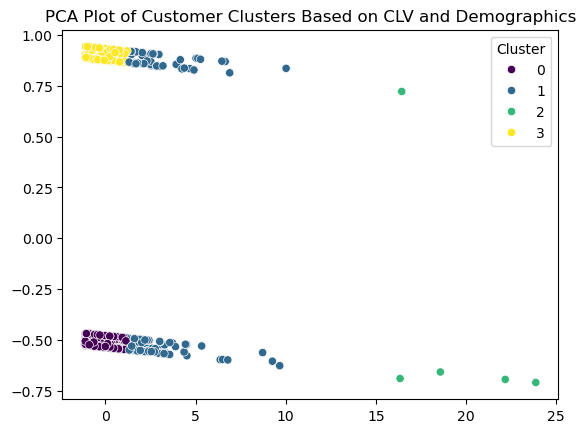

Average Silhouette Score: 0.31
Cluster 0: Enhance loyalty programs for high CLV customers.
Cluster 1: Introduce personalized marketing for medium CLV customers.
Cluster 2: Develop re-engagement tactics for low CLV customers.
Cluster 3: Explore new acquisition channels for potential high-value customers.


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# Configure warnings
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")
warnings.filterwarnings("ignore", category=FutureWarning)

# Load datasets
df_sales = pd.read_csv('../data/Online_Sales.csv')
df_customers = pd.read_excel('../data/CustomersData.xlsx')

# Preprocess sales data
df_sales['Transaction_Date'] = pd.to_datetime(df_sales['Transaction_Date'])
df_sales['Total_Spent'] = df_sales['Quantity'] * df_sales['Avg_Price'] + df_sales['Delivery_Charges']

# Calculate CLV
df_sales['CLV'] = df_sales['Total_Spent'] * 0.1  # Assuming a 10% profit margin

# Aggregate sales data at the customer level
df_customer_agg = df_sales.groupby('CustomerID').agg({
    'Total_Spent': 'sum',
    'CLV': 'sum',
    'Transaction_Date': 'count'
}).rename(columns={'Transaction_Date': 'Frequency'})

# Merge with customer demographics
df_merged = pd.merge(df_customer_agg, df_customers, on='CustomerID', how='left')

# Feature engineering and preprocessing
features = ['Total_Spent', 'Frequency', 'CLV']
categorical_features = df_customers.select_dtypes(include=['object']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
X_processed = preprocessor.fit_transform(df_merged)

# K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df_merged['Cluster'] = kmeans.fit_predict(X_processed)

# Visualizing the clusters using PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X_processed)
sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1], hue=df_merged['Cluster'], palette='viridis')
plt.title('PCA Plot of Customer Clusters Based on CLV and Demographics')
plt.show()

# Silhouette analysis to evaluate cluster quality
silhouette_avg = silhouette_score(X_processed, df_merged['Cluster'])
print(f'Average Silhouette Score: {silhouette_avg:.2f}')

# Developing strategies for each cluster
strategies = {
    0: "Enhance loyalty programs for high CLV customers.",
    1: "Introduce personalized marketing for medium CLV customers.",
    2: "Develop re-engagement tactics for low CLV customers.",
    3: "Explore new acquisition channels for potential high-value customers."
}
for cluster, strategy in strategies.items():
    print(f"Cluster {cluster}: {strategy}")

